In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Disclaimer :** Before, we go any further, Let me clear that You would need **GPU** and **Internet**- toggle turned **ON** (install external libraries) to succesfully run this kernel.

![Begin](https://pbs.twimg.com/tweet_video_thumb/ECvtpBRXoAIpyUv.jpg)

Img source : https://pbs.twimg.com/tweet_video_thumb/ECvtpBRXoAIpyUv.jpg

In [ ]:
# pytorch_pretained_bert already available in kaggle conda env.
# !pip install pytorch-nlp

**Note :** uncomment the code line in above cell; you are running this notebook locally, and would need pytorch-nlp library.Here, it is pre-installed.

### importing necessaries libraries...

In [2]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Initializing seed values to stabilize the outcomes.

In [3]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

## Prepare the data

In [4]:
path = '../input/imdb-50k-movie-reviews-test-your-bert/'

train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')

In [5]:
train_data.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [6]:
train_data.size

50000

In [7]:
# experimenting here with a sample of dataset, to avoid memory overflow.
train_data = train_data[:5000]
test_data = test_data[:800]

train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
type(train_data)

list

In [8]:
train_data[:2]

[{'text': "Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it.",
  'sentiment': 'neg'},
 {'text': 'The saddest thing about this "tribute" is that almost all the singers (including the otherwise incredibly talented Nick Cave) seem to have missed the whole point where Cohen\'s intensity lies: by delivering his lines in an almost tun

### Mapping sentences with their Labels...

In [9]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(5000, 5000, 800, 800)

#### visualizing one of the sentences from train set

In [10]:
train_texts[0]

"Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it."

## visualizing sentences lengths

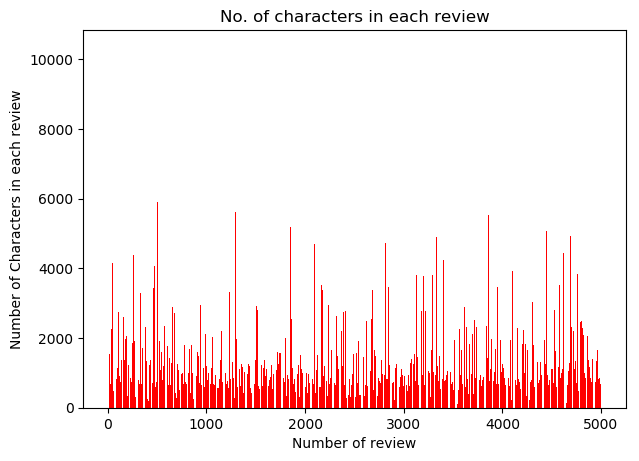

In [11]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,5001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each review', xlabel='Number of review', ylabel='Number of Characters in each review');

#### We can see that most of the sentences are around 700 - 1000 characters long, which is pretty obvious. HOwever, few sentences are shorter and few even long as 6000 characters. So, this is a good, very versatile Review Dataset.

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 933456.38B/s]


In [13]:
tokenizer.tokenize('Hi my name is Alex')

['hi', 'my', 'name', 'is', 'alex']

### Sample of how BERT Tokenizer works and Embeddings prepared to be fed into BERT Model.

![BERT TOKENS](https://miro.medium.com/max/619/1*iJqlhZz-g6ZQJ53-rE9VvA.png)

## Preparing Token embeddings...

In [15]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)
#cls (начало предложения), sep (конец предложения) - токены для обучения берт

(5000, 800)

In [16]:
train_tokens[0]

['[CLS]',
 'now',
 ',',
 'i',
 'won',
 "'",
 't',
 'deny',
 'that',
 'when',
 'i',
 'purchased',
 'this',
 'off',
 'e',
 '##bay',
 ',',
 'i',
 'had',
 'high',
 'expectations',
 '.',
 'this',
 'was',
 'an',
 'incredible',
 'out',
 '-',
 'of',
 '-',
 'print',
 'work',
 'from',
 'the',
 'master',
 'of',
 'comedy',
 'that',
 'i',
 'so',
 'enjoy',
 '.',
 'however',
 ',',
 'i',
 'was',
 'soon',
 'to',
 'be',
 'disappointed',
 '.',
 'apologies',
 'to',
 'those',
 'who',
 'enjoyed',
 'it',
 ',',
 'but',
 'i',
 'just',
 'found',
 'the',
 'com',
 '##ple',
 '##at',
 'al',
 'to',
 'be',
 'very',
 'difficult',
 'to',
 'watch',
 '.',
 'i',
 'got',
 'a',
 'few',
 'smiles',
 ',',
 'sure',
 ',',
 'but',
 'the',
 'majority',
 'of',
 'the',
 'funny',
 'came',
 'from',
 'the',
 'music',
 'videos',
 '(',
 'which',
 'i',
 "'",
 've',
 'got',
 'on',
 'dvd',
 ')',
 'and',
 'the',
 'rest',
 'was',
 'basically',
 'fill',
 '##er',
 '.',
 'you',
 'could',
 'tell',
 'that',
 'this',
 'was',
 'not',
 'al',
 "'",
 '

## Preparing Token Ids...


![token ids](https://jalammar.github.io/images/distilBERT/sst2-text-to-tokenized-ids-bert-example.png)

In [17]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((5000, 512), (800, 512))

### Many a times your Kernel will Freeze but this is just OK. Let it be. This is a heavy computing task; So,it is just a common thing to happen. I have also put Monitoring code snippets to monitor your CPU/GPU usage and also Garbage Collector to free up space.


It is quite common to see your CPU floating above 100% and/or GPU over 100% like these screens below:
![SNAP-1](https://i.ibb.co/3cFD5Hs/cut-1.png)
![SNAP-2](https://i.ibb.co/G5qFRxj/cut-2.png)

In [18]:
#делаем массив из булевых значений (true = pos, false = neg)
#mean - доля позитивных отзывов в выборке => видим, что примерно равномерная выборка
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((5000,), (800,), 0.4938, 0.4875)

### Now Masking few random IDs from each sentences to remove Biasness from model.

In [19]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [20]:
train_masks[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

# Baseline

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [22]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
baseline_predicted = baseline_model.predict(test_texts)

In [24]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.88      0.85      0.87       410
         pos       0.85      0.87      0.86       390

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800



#### Our baseline model is working just fine and yeilding a fair enough score. Now, its time to play Dirty with the "BERT".

# BERT Model


### Bidirectional Encoder Representations from Transformers. Each word here has a meaning to it and we will encounter that one by one in this article. For now, the key takeaway from this line is – **BERT is based on the Transformer architecture**.

In [25]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [26]:
# ensuring that the model runs on GPU, not on CPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [28]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

100%|██████████| 407873900/407873900 [00:10<00:00, 38371704.88B/s]


In [29]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [30]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [31]:
y = bert_clf(x)
y.cpu().detach().numpy()        # kinda Garbage Collector to free up used and cache space

array([[0.4249209 ],
       [0.4760142 ],
       [0.37757647]], dtype=float32)

In [32]:
# Cross- checking CUDA GPU Memory to ensure GPU memory is not overflowing.
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6697.349632M'

In [33]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

# Fine Tune BERT

In [34]:
# Setting hyper-parameters

BATCH_SIZE = 4
EPOCHS = 8

In [35]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [36]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [37]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [38]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [39]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

In [40]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        #clip_grad_norm_ performs gradient clipping. It is used to mitigate the problem of 
        #exploding gradients, which is of particular concern for recurrent networks
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  8
1249/1250.0 loss: 0.04749007382955169 


In [45]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])


In [46]:
np.mean(bert_predicted)

0.5025

In [47]:
list(zip(test_texts[:5], bert_predicted[:5]))

[('My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn\'t awful enough to see "product placement" actors like Bruce Willis who smoke in their movies - at least children movies should be more considerate! I wonder: was that intentional? Did big tobacco "sponsor" the film? What does it take to ban smoking from films? At least films intended for children and adolescents. My daughter liked it but I was aghast, that a character in this movie smokes. As if it isn\'t awful enough to see "product placement" actors like Bruce Willis who smoke in their movies - at least children movies should be more considerate! I wonder: was that intentional? Did big tobacco "sponsor" the film? What does it take to ban smoking from films? At least films intended for children and adolescents.',
  False),
 ("I... No words. No words can describe this. I will try for the sake of those few brave people who stick knives into their toasters... after watching this show.<br /><br 

In [48]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

       False       0.93      0.91      0.92       410
        True       0.91      0.93      0.92       390

    accuracy                           0.92       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.92      0.92      0.92       800



In [ ]:
torch.save(bert_clf.state_dict(), "/kaggle/working/bert_transfer_learning_for_film_reviews.pt")